In [2]:
# Basic Data Handling and Scientific Computing
import numpy as np
import pandas as pd
import scipy.stats as stats
import joblib
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, chi2_contingency

# Preprocessing and Model Selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Oversampling
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt

# Miscellaneous
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Path to dataset
file_path = r'\Datasets\application_data.csv'

# Function to load data
def load_data(file_path):
    return pd.read_csv(file_path)

def detect_imbalance(data, target_column, threshold=0.10):
    # Calculate the proportions of each class in the target column
    class_counts = data[target_column].value_counts(normalize=True)
    
    # Check if any class proportion is less than the threshold
    is_imbalanced = any(class_counts < threshold) or any(class_counts > (1 - threshold))
    
    # Print out the class proportions and whether the dataset is imbalanced
    print(f"Class proportions:\n{class_counts}")
    print(f"Dataset is imbalanced: {is_imbalanced}")

    # Define a list of colors, one for each class
    colors = ['red', 'blue'] 
    
    # Plotting the histogram
    plt.figure(figsize=(3, 2))
    class_counts.plot(kind='bar', color=colors[:len(class_counts)])
    plt.xlabel('Class')
    plt.ylabel('Proportion')
    plt.title('Histogram of Target Class Proportions')
    plt.show()
    
    return is_imbalanced

# Function to drop the 'SK_ID_CURR' ID column
def drop_id_column(data):
    data = data.drop(columns=['SK_ID_CURR'])
    return data

# Function to filter out columns with more than 25% missing values
def filter_columns(data, threshold=0.25):
    missing_proportions = data.isnull().mean()
    columns_to_keep = missing_proportions[missing_proportions < threshold].index.tolist()
    data = data[columns_to_keep]
    return data, missing_proportions, columns_to_keep

# Function to filter out rows with more than 25% missing values
def filter_rows(data, threshold=0.25):
    missing_value_proportion_per_row = data.isnull().mean(axis=1)
    data = data.loc[missing_value_proportion_per_row <= threshold]
    return data, missing_value_proportion_per_row

# Function to print the missing data statistics
def print_missing_data_stats(missing_proportions, columns_to_keep, missing_value_proportion_per_row):
    print("Proportion of missing data per column:")
    print(missing_proportions)

    print("\nColumns with less than 25% missing data:")
    print(columns_to_keep)

    rows_with_high_missing_values = missing_value_proportion_per_row[missing_value_proportion_per_row > 0.25]
    print(f"Number of rows with missing value proportion > 0.25: {len(rows_with_high_missing_values)}")

# Function to label encode object-type columns
def label_encode_data(data):
    le = LabelEncoder()
    label_mappings = {}
    for col in data.columns:
        if data[col].dtype == object:
            data[col] = le.fit_transform(data[col])
            label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    return data, label_mappings

# Function to convert list of float columns to integers
def convert_floats_to_ints(data, columns_list):
    data[columns_list] = data[columns_list].astype('Int64')
    return data

# List of columns to convert from float to int
lst_flt_to_int = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                  'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
                  'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
                  'DAYS_LAST_PHONE_CHANGE','DEF_60_CNT_SOCIAL_CIRCLE',
                  'OBS_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE',
                  'OBS_30_CNT_SOCIAL_CIRCLE','CNT_FAM_MEMBERS']

# Function to fill missing values with mode for all columns
def fill_missing_with_mode(data):
    # First, calculate the modes and store them in a dictionary
    modes_dict = {}
    for column in data.columns:
        mode_value = data[column].mode()[0]
        modes_dict[column] = mode_value
    
    # Now use the modes to fill in missing values
    for column, mode_value in modes_dict.items():
        data[column].fillna(mode_value, inplace=True)
    return data, modes_dict

# Function to check for normality
def normality_test(group):
    stat, p_value = shapiro(group)
    return p_value > 0.05  # Assuming alpha is 0.05

# Function to check for homogeneity of variances
def homogeneity_test(group1, group2):
    stat, p_value = levene(group1, group2)
    return p_value > 0.05  # Assuming alpha is 0.05

def decide_and_test(feature, data):
    # If feature is categorical or binary, perform chi-square test
    if data[feature].dtype == 'object' or data[feature].nunique() <= 50:
        contingency_table = pd.crosstab(data[feature], data['TARGET'])
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        return 'Chi-Square', chi2, p_value
    # If feature is numeric and continuous, perform t-test or Mann-Whitney test
    elif data[feature].dtype in [np.float64, np.int64,np.int32] and data[feature].nunique() > 50:
        group1 = data[data['TARGET'] == 0][feature].dropna()
        group2 = data[data['TARGET'] == 1][feature].dropna()
        # Check for normality and homogeneity of variances
        if normality_test(group1) and normality_test(group2) and homogeneity_test(group1, group2):
            stat, p_value = ttest_ind(group1, group2, equal_var=True)
            return 'T-test', stat, p_value
        else:
            stat, p_value = mannwhitneyu(group1, group2)
            return 'Mann-Whitney', stat, p_value
    else:
        # For features that do not meet any of the above conditions, no test is performed
        return 'Other', None, None

def statistical_significance_filter(data):
    test_results = []
    for feature in data.columns:
        if feature != 'TARGET':  # Exclude the target variable
            test_type, stat, p_value = decide_and_test(feature, data)
            # Handle None values by not appending them to the results
            if test_type != 'Other':
                test_results.append({
                    'Feature': feature,
                    'Test Type': test_type,
                    'Statistic': stat if stat is not None else 'N/A',
                    'p-value': p_value if p_value is not None else 'N/A'
                })
    test_results_df = pd.DataFrame(test_results)
    
    # Format the p-values and statistics for readability
    test_results_df['p-value'] = test_results_df['p-value'].apply(lambda x: f"{x:.3f}" if x != 'N/A' else x)
    test_results_df['Statistic'] = test_results_df['Statistic'].apply(lambda x: f"{x:.3f}" if x != 'N/A' else x)
    test_results_df['p-value'] = pd.to_numeric(test_results_df['p-value'], errors='coerce')

    # Filter out the significant features
    sign_features = test_results_df[test_results_df['p-value'] < 0.05]['Feature'].tolist()
    data = data[sign_features + ['TARGET']]
    
    return data, test_results_df, sign_features

def remove_multicollinearity(data, threshold=0.8):
    # Calculate the correlation matrix
    corr = data.corr()

    # Create a boolean mask for features to drop
    to_drop = set()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold:
                to_drop.add(corr.columns[i])

    # Drop features from the data
    data = data.drop(columns=to_drop)
    return data, to_drop

# Function to apply PCA on FLAG_DOCUMENT features
def apply_pca_flag_documents(data, columns, n_components):
    data_pca = data[columns]
    scaler = StandardScaler()
    data_pca_scaled = scaler.fit_transform(data_pca)
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(data_pca_scaled)

    # Save the scaler and PCA objects for later use
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(pca, 'pca.pkl')
    
    # Calculate the sum of explained variance ratios
    explained_variance_sum = sum(pca.explained_variance_ratio_)
    print(f"Sum of explained variance ratios for FLAG_DOCUMENT: {explained_variance_sum:.3f}")

    # Creating a DataFrame with the PCA components
    pca_df = pd.DataFrame(data=principalComponents, 
                          columns=[f'PC_flag_{i+1}' for i in range(n_components)],
                          index=data.index)
    # Drop the original PCA columns from the data and concatenate the new PCA components
    return pd.concat([data.drop(columns=columns), pca_df], axis=1)

# Function to preprocess and oversample data
def preprocess_and_oversample(data):
    # Separate input features and target
    X = data.drop('TARGET', axis=1)
    y = data['TARGET']

    # Identify categorical columns that need to be one-hot encoded
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    # Create a column transformer with OneHotEncoder for categorical variables
    column_transformer = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'  # leave the rest of the columns untouched
    )

    # Apply column transformer to X
    X_encoded = column_transformer.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    # Initialize the SMOTE object
    smote = SMOTE(random_state=42)

    # Apply SMOTE to the training data only
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Retrieve the feature names from the column transformer
    # This will be a list of all the new feature names after one-hot encoding
    new_feature_names = column_transformer.get_feature_names_out()

    # Create a DataFrame with the oversampled features
    oversampled_features = pd.DataFrame(X_train_smote, columns=new_feature_names)

    # Add the oversampled target variable to the DataFrame
    oversampled_features['TARGET'] = y_train_smote

    print('Count of each classes after oversampling:', oversampled_features['TARGET'].value_counts())
    print('Sum of missing value count in dataset:', oversampled_features.isnull().sum().sum())

    return oversampled_features, X_test, y_test

# Function to train and evaluate the XGBoost classifier
def train_and_evaluate(data, X_test, y_test):
    # Separate input features and target variable
    X = data.drop('TARGET',axis=1)
    y = data['TARGET']

    # Split dataset into training set and test set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
    
    # Initialize the XGBoost classifier
    clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    
    # Predict on test set
    y_pred_test = clf.predict(X_test)
    
    # Evaluate the predictions on test set
    print('Test Metrics (Before oversampling):')
    print('Accuracy Score:', round(accuracy_score(y_test, y_pred_test), 4))
    print('Precision Score:', round(precision_score(y_test, y_pred_test), 4))
    print('Recall Score:', round(recall_score(y_test, y_pred_test), 4))
    print('F1 Score:', round(f1_score(y_test, y_pred_test), 4))
    print('-----------------------------------')

    # Predict on validation set
    y_pred = clf.predict(X_val)
    
    # Evaluate the predictions
    print('Validation Metrics (After oversampling):')
    print('Accuracy Score:', round(accuracy_score(y_val, y_pred), 4))
    print('Precision Score:', round(precision_score(y_val, y_pred), 4))
    print('Recall Score:', round(recall_score(y_val, y_pred), 4))
    print('F1 Score:', round(f1_score(y_val, y_pred), 4))
    print('-----------------------------------')
    
    return clf  # Optionally return the trained model

def select_best20_features(data,features_number):
    # Assuming data is your preprocessed DataFrame and 'TARGET' is the target variable
    X = data.drop('TARGET', axis=1)
    y = data['TARGET']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the classifier
    clf= RandomForestClassifier(n_estimators=100, random_state=42)

    # Fit the classifier on the training data
    clf.fit(X_train, y_train)

    # Get feature importances
    importances = clf.feature_importances_

    # Sort feature importances in descending order and select the indices of the top 20
    indices = importances.argsort()[-features_number:][::-1]

    # If you need to get the feature names as well
    feature_names = X_train.columns[indices]
    
    # Create a new DataFrame with only the selected columns
    data = data[['TARGET'] + feature_names.tolist()]

    return data, feature_names

def train_and_evaluate_20_features(data, X_test, y_test):
    # Separate input features and target variable
    X = data.drop('TARGET',axis=1)
    y = data['TARGET']

    # Split dataset into training set and test set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
    
    # Initialize the XGBoost classifier
    clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    
    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = clf.predict(X_val)
    
    # Evaluate the predictions
    print('Classes of predictions',y_pred)
    print('Validation Metrics (After oversampling and using best 20 features):')
    print('Accuracy Score:', round(accuracy_score(y_val, y_pred), 4))
    print('Precision Score:', round(precision_score(y_val, y_pred), 4))
    print('Recall Score:', round(recall_score(y_val, y_pred), 4))
    print('F1 Score:', round(f1_score(y_val, y_pred), 4))
    print('-----------------------------------')

    return clf  # Optionally return the trained model

# List of columns on which to perform PCA
pca_columns_1 = [
       'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_18']

Class proportions:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
Dataset is imbalanced: True


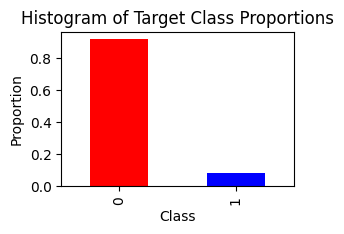

Sum of explained variance ratios for FLAG_DOCUMENT: 0.711
Count of each classes after oversampling: TARGET
0    226132
1    226132
Name: count, dtype: int64
Sum of missing value count in dataset: 0
Test Metrics (Before oversampling):
Accuracy Score: 0.9187
Precision Score: 0.4109
Recall Score: 0.0228
F1 Score: 0.0433
-----------------------------------
Validation Metrics (After oversampling):
Accuracy Score: 0.956
Precision Score: 0.9974
Recall Score: 0.9147
F1 Score: 0.9542
-----------------------------------
Classes of predictions [1 1 1 ... 0 1 1]
Validation Metrics (After oversampling and using best 20 features):
Accuracy Score: 0.9548
Precision Score: 0.9975
Recall Score: 0.9124
F1 Score: 0.953
-----------------------------------


In [4]:
# existing pipeline steps
data = load_data(file_path)
detect_imbalance(data, 'TARGET')
data = drop_id_column(data)
data, missing_proportions, columns_to_keep = filter_columns(data)
data, missing_value_proportion_per_row = filter_rows(data)
data, label_mappings = label_encode_data(data)
data = convert_floats_to_ints(data, lst_flt_to_int)
data, modes_dict = fill_missing_with_mode(data)
data, test_results_df, sign_features= statistical_significance_filter(data)
data, to_drop = remove_multicollinearity(data)
data = apply_pca_flag_documents(data, pca_columns_1, 7)
data, X_test, y_test = preprocess_and_oversample(data)
model = train_and_evaluate(data, X_test, y_test)
data, feature_names = select_best20_features(data,20)
# after selecting best 20 features  
model= train_and_evaluate_20_features(data, X_test, y_test)


#### Functions to predict the class of any customer after data pre-processing processes after raw data entry

In [5]:
def encode_new_data_single_row(single_row, label_mappings):
    # Ensure single_row is a Pandas Series
    if not isinstance(single_row, pd.Series):
        raise ValueError("single_row must be a pandas Series")

    # Copy the single data row
    encoded_row = single_row.copy()

    # Apply label encoding for each column
    for col in label_mappings:
        # Check if this column is in the new data and is categorical
        if col in encoded_row.index:
            # Get the value for the column
            value = single_row[col]

            # Check if the value is NaN (use pd.isna for robustness)
            if pd.isna(value):
                encoded_row[col] = -1  # or another strategy for handling NaNs
            else:
                # Try to get the corresponding label
                try:
                    encoded_row[col] = label_mappings[col][value]
                except KeyError:
                    # If the categorical value is not seen in the training set
                    encoded_row[col] = -1  # or another strategy for unseen values
    return encoded_row

def fill_missing_values_for_single_row(single_row, modes_dict):
    for column, mode_value in modes_dict.items():
        if pd.isnull(single_row[column]):
            single_row[column] = mode_value
    return single_row

def sign_features_selection(df):
    df = df[sign_features + ['TARGET']]
    return df

def remove_multicollinearity_selection(df):
    # Drop features from the data
    df = df.drop(columns=to_drop)
    return df

def apply_pca_to_new_row(new_row, columns):
    # Load the saved scaler and PCA
    scaler = joblib.load('scaler.pkl')
    pca = joblib.load('pca.pkl')

    # Extract the relevant features from the new row
    new_row_pca = new_row[columns]
    if isinstance(new_row_pca, pd.Series):
        new_row_pca = new_row_pca.to_frame().transpose()

    # Standardize and apply PCA to the new row
    new_row_scaled = scaler.transform(new_row_pca)
    new_row_principalComponents = pca.transform(new_row_scaled)

    # Creating a DataFrame with the PCA components
    pca_df = pd.DataFrame(data=new_row_principalComponents, 
                          columns=[f'PC_flag_{i+1}' for i in range(joblib.load('pca.pkl').n_components)]
                          ,index=new_row.index)
    # Drop the original PCA columns from the data and concatenate the new PCA components
    return pd.concat([new_row.drop(columns=columns), pca_df], axis=1) 

def select_best20_features_row(df,features_number):

    # Create a new DataFrame with only the selected columns
    new_feature_names = [name.replace('remainder__', '') for name in feature_names]
    df = df[['TARGET'] + new_feature_names]

    return df

In [7]:
def process_and_predict(file_path, row_index, label_mappings, modes_dict, model, lst_flt_to_int, pca_columns_1, feature_names, to_drop):
    # Load the specific row from the dataset (To show the functionality of the functions)
    data_row = pd.read_csv(file_path).iloc[row_index, :] # or we can also enter any record that has the properties in the dataset

    # Sequentially apply all processing functions
    data_row = drop_id_column(data_row)
    data_row = encode_new_data_single_row(data_row, label_mappings)
    data_row = convert_floats_to_ints(data_row, lst_flt_to_int)
    data_row = fill_missing_values_for_single_row(data_row, modes_dict)
    data_row = sign_features_selection(data_row)
    data_row = remove_multicollinearity_selection(pd.DataFrame(data_row).T)
    data_row = apply_pca_to_new_row(data_row, pca_columns_1)
    data_row = select_best20_features_row(data_row, 20)

    # Predict and return the class of the processed record
    prediction = model.predict(np.array(data_row.drop('TARGET', axis=1)))
    return prediction

# Example usage
file_path = r'\Datasets\application_data.csv'
row_index = 2  # For example, to process the third row (index 2)
print('Prediction class of entered record:')
prediction = process_and_predict(file_path, row_index, label_mappings, modes_dict, model, lst_flt_to_int, pca_columns_1, feature_names, to_drop)
print(prediction)


Prediction class of entered record:
[0]
